# Lattice Boltzmann

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
from IPython.display import HTML, display
import base64

In [19]:
def equilibrium_distribution(rho, u, v, weights, c):
    """
    Compute the equilibrium distribution function using the BGK approximation.
    """
    cu = np.zeros((9, ny, nx))
    for i, ci in enumerate(c):
        cu[i] = ci[0] * u + ci[1] * v  # Calculate dot product for each direction
    usqr = u**2 + v**2
    feq = np.zeros((9, ny, nx))
    for i in range(9):
        feq[i] = weights[i] * rho * (1 + 3*cu[i] + 9/2*cu[i]**2 - 3/2*usqr)
    return feq


def lattice_boltzmann_simulation(Lx, Ly, nx, ny, num_steps, tau, obstacle):
    c = np.array([[1, 0], [0, 1], [-1, 0], [0, -1], [1, 1], [-1, 1], [-1, -1], [1, -1], [0, 0]])
    weights = np.array([1/9, 1/9, 1/9, 1/9, 1/36, 1/36, 1/36, 1/36, 4/9])
    rho = np.ones((ny, nx))
    u = np.zeros((ny, nx))
    v = np.zeros((ny, nx))
    
    f = equilibrium_distribution(rho, u, v, weights, c)
    
    solution = {'Lx': Lx, 'Ly': Ly, 'nx': nx, 'ny': ny, 'u': [], 'v': []}
    
    for step in range(num_steps):
        # Streaming
        for i, ci in enumerate(c):
            f[i] = np.roll(f[i], ci, axis=(0, 1))
        
        # Apply bounce-back condition for the obstacle
        f[:, obstacle] = f[:, obstacle][:, ::-1]
        
        # Collision
        rho = np.sum(f, axis=0)
        u = np.dot(f.T, c[:,0]) / rho
        v = np.dot(f.T, c[:,1]) / rho
        feq = equilibrium_distribution(rho, u, v, weights, c)
        f += -(1.0 / tau) * (f - feq)
        
        # Store results
        if step % 2 == 0:  # Example: save every 2 steps
            solution['u'].append(u.copy())
            solution['v'].append(v.copy())
    
    return solution


def display_simulation_as_gif(simulation_output, filename='lattice_boltzmann_simulation.gif'):
    Lx = simulation_output['Lx']
    Ly = simulation_output['Ly']
    nx = simulation_output['nx']
    ny = simulation_output['ny']
    u_outputs = simulation_output['u']
    v_outputs = simulation_output['v']
    
    X, Y = np.linspace(0, Lx, nx), np.linspace(0, Ly, ny)

    fig, ax = plt.subplots(figsize=(6, 6))
    frames = []

    for n, (u, v) in enumerate(zip(u_outputs, v_outputs)):
        ax.clear()
        speed = np.sqrt(u**2 + v**2)
        # Use a constant linewidth for visibility
        linewidth = 1.0
    
        # Optionally, normalize speed for color mapping if it varies significantly
        norm_speed = speed / speed.max()
    
        strm = ax.streamplot(X, Y, u, v, color='blue', density=1.5, linewidth=linewidth)
        ax.set_title(f'Time step {n}')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')

        fig.canvas.draw()
        image = np.array(fig.canvas.buffer_rgba())  # Updated to use buffer_rgba
        frames.append(image)
    
    plt.close(fig)

    with imageio.get_writer(filename, mode='I', duration=0.1, loop=0) as writer:
        for frame in frames:
            writer.append_data(frame)
    
    with open(filename, 'rb') as file:
        data = file.read()
        data_url = 'data:image/gif;base64,' + base64.b64encode(data).decode()
    display(HTML(f'<img src="{data_url}" alt="Lattice Boltzmann Simulation"/>'))


In [17]:
nx, ny = 100, 100
Lx, Ly = 2.0, 2.0
num_steps = 100
tau = 0.6  # Relaxation time
obstacle = np.fromfunction(lambda y, x: (x - nx / 4)**2 + (y - ny / 2)**2 < (ny / 10)**2, (ny, nx))

# Run the simulation
solution1 = lattice_boltzmann_simulation(Lx, Ly, nx, ny, num_steps, tau, obstacle)

In [24]:
solution1['u']

[array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 arr

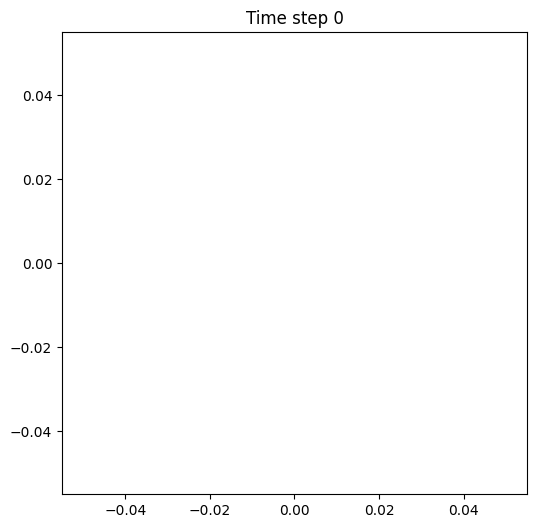

In [23]:
# Plot a single frame to check visualization
u_outputs = solution1['u']
v_outputs = solution1['v']

n = 0  # Example: First frame
u, v = u_outputs[n], v_outputs[n]
speed = np.sqrt(u**2 + v**2)

X, Y = np.linspace(0, Lx, nx), np.linspace(0, Ly, ny)

fig, ax = plt.subplots(figsize=(6, 6))
strm = ax.streamplot(X, Y, u, v, color='blue', density=1.5, linewidth=1.0)
ax.set_title(f'Time step {n}')
plt.show()

/var/folders/vy/vr0_ytms6m95qrnk7xnh0bth0000gq/T/ipykernel_45918/1411864556.py:69: RuntimeWarning: invalid value encountered in divide
  norm_speed = speed / speed.max()



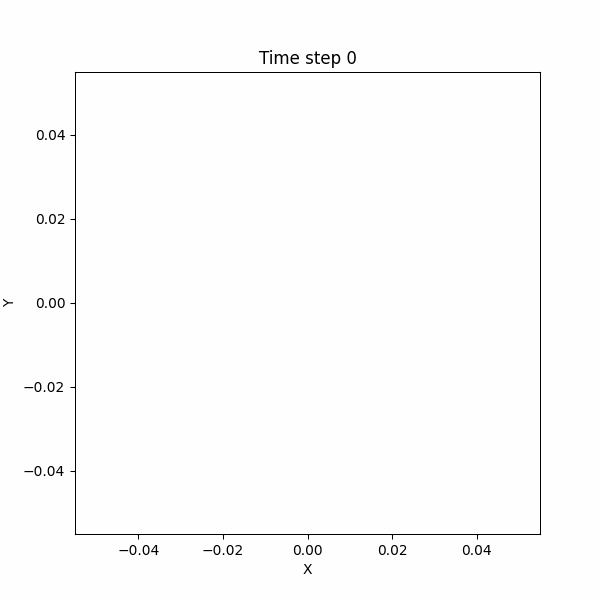

In [20]:
display_simulation_as_gif(solution1)